# Exercice: agrégation
Nous verrons ici comment agréger une table input-output. Différentes raisons peuvent pousser à agréger/désagréger une table existante, notamment afin de la faire correspondre à un jeu de données externe (avec une classification différente) ou encore d'effectuer les calculs plus rapidement (la complexité augmente avec le carré de la résolution).

In [50]:
import pymrio as mr   # manipulation des données input-output
import pandas as pd   # manipulation de tables et jeux de données
import numpy as np    # opérations communes
import seaborn as sns # production de figures, add-on à matplotlib
import matplotlib.pyplot as plt # production de figures
import os # opérations sur le système de fichiers

from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

In [2]:
# Si vous voulez enregistrer/charger rapidement
import pickle

In [3]:
year = 2019
EXIOBASE_PATH = '../EXIOBASE/' # ne pas hésiter à changer

In [4]:
# Chargement rapide des données IO
with open(EXIOBASE_PATH + f'IOT_{year}_ixi.pickle', 'rb') as handle:
    io = pickle.load(handle)

In [5]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Agrégation des secteurs

In [6]:
# Chargement du fichier de correspondance pour les secteurs
sec_agg_raw = pd.read_excel('data/NACE2full_EXIOBASEp.xlsx')

In [7]:
sec_agg_raw_lvl1 = sec_agg_raw[sec_agg_raw['Level']==1].drop(['Unnamed: 2','Unnamed: 3','Level'], axis=1)

sec_agg = sec_agg_raw_lvl1.set_index('Code').stack().droplevel(1)

sec_agg_dict = {v:k for k,v in sec_agg.items()}

# Les libellés ne sont pas exactement les mêmes dans le fichier importé...
sec_agg_dict['Manure treatment (conventional), storage and land application'] = sec_agg_dict['Manure treatment (conventional) and land application']
sec_agg_dict['Manure treatment (biogas), storage and land application'] = sec_agg_dict['Manure treatment (biogas) and land application']
sec_agg_dict['Re-processing of secondary wood material into new wood material'] = sec_agg_dict['Woodwaste']
sec_agg_dict['Re-processing of secondary paper into new pulp'] = sec_agg_dict['Recycling of waste paper']
sec_agg_dict['Re-processing of secondary plastic into new plastic'] = sec_agg_dict['Recycling of plastics waste']
sec_agg_dict['Re-processing of secondary glass into new glass'] = sec_agg_dict['Recycling of waste and scrap']
sec_agg_dict['Re-processing of secondary aluminium into new aluminium'] = sec_agg_dict['Recycling of aluminium waste']
sec_agg_dict['Re-processing of secondary copper into new copper'] = sec_agg_dict['Recycling of copper waste']
sec_agg_dict['Re-processing of secondary lead into new lead, zinc and tin'] = sec_agg_dict['Recycling of lead, zinc and tin waste']
sec_agg_dict['Re-processing of secondary other non-ferrous metals into new other non-ferrous metals'] = sec_agg_dict['Recycling of aluminium waste']
sec_agg_dict['Re-processing of secondary plastic into new plastic'] = sec_agg_dict['Recycling of waste and scrap']
sec_agg_dict['Re-processing of secondary preciuos metals into new preciuos metals'] = sec_agg_dict['Recycling of pecious metals waste']
sec_agg_dict['Re-processing of secondary steel into new steel'] = sec_agg_dict['Recycling of steel scrap']
sec_agg_dict['Re-processing of secondary construction material into aggregates'] = sec_agg_dict['Recycling of construction waste']
sec_agg_dict['Recycling of bottles by direct reuse'] = sec_agg_dict['Glass bottles directly reused']
sec_agg_dict['Re-processing of ash into clinker'] = sec_agg_dict['Glass bottles directly reused']
sec_agg_dict['Biogasification of food waste, incl. land application'] = sec_agg_dict['Biogasification of food waste']
sec_agg_dict['Biogasification of paper, incl. land application'] = sec_agg_dict['Biogasification of paper']
sec_agg_dict['Biogasification of sewage slugde, incl. land application'] = sec_agg_dict['Biogasification of sewage slugde']
sec_agg_dict['Composting of food waste, incl. land application'] = sec_agg_dict['Composting of food waste']
sec_agg_dict['Composting of paper and wood, incl. land application'] = sec_agg_dict['Composting of paper and wood']

# Ces trois là sont des approximations, mais la catégorie principale est la même (NACE "E")
sec_agg_dict['Landfill of waste: Inert/metal/hazardous'] = sec_agg_dict['Incineration of waste: Metals and Inert materials']
sec_agg_dict['Landfill of waste: Textiles'] = sec_agg_dict['Incineration of waste: Textiles']
sec_agg_dict['Landfill of waste: Wood'] = sec_agg_dict['Incineration of waste: Wood']


## Agrégation des régions

In [8]:
# Paramètres de l'agrégation pour les pays
reg_agg_dict = dict(zip(io.get_regions(), ['EU28'] * 28 + ['RoW'] * 21))

for c in ['LU', 'BE', 'FR', 'DE', 'NL', 'CH']:
    reg_agg_dict[c] = c

In [9]:
io_LU = io.copy()

io_LU.rename_sectors(sec_agg_dict).aggregate_duplicates()
io_LU.rename_regions(reg_agg_dict).aggregate_duplicates()

In [10]:
# On recalcule le tout
io_LU.calc_all()

In [11]:
io_LU.A.shape

(168, 168)

Nous avons à présent une classification de 8 régions × 21 secteurs = 168, ce qui rendra les calculs plus simples.

In [12]:
# Il reste à remplacer les noms des catégories
nace2_labels = pd.read_excel('data/NACE2_labels.xlsx', index_col=0)

In [13]:
io_LU.rename_sectors(nace2_labels.to_dict()['Label'])

In [14]:
# Et on sauvegarde le tout dans un fichier Excel
writer = pd.ExcelWriter('excel/io_LU_2019.xlsx', engine='xlsxwriter')

io_LU.Z.to_excel(writer, sheet_name='Z')
io_LU.x.to_excel(writer, sheet_name='x')
io_LU.Y.to_excel(writer, sheet_name='Y')
io_LU.A.to_excel(writer, sheet_name='A')
io_LU.L.to_excel(writer, sheet_name='L')

io_LU.impacts.F.to_excel(writer, sheet_name='F_impacts')
io_LU.satellite.F.to_excel(writer, sheet_name='F_satellite')

io_LU.impacts.S.to_excel(writer, sheet_name='S_impacts')
io_LU.satellite.S.to_excel(writer, sheet_name='S_satellite')

writer.close()

## Empreinte du Luxembourg

Regardons l'empreinte carbone avec l'indicateur GWP100.

In [15]:
ind = 'GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)'

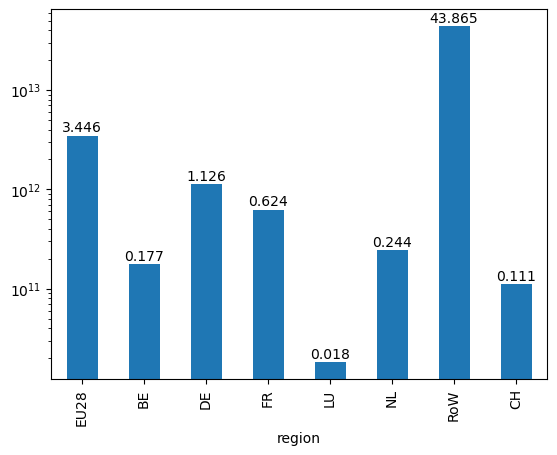

In [16]:
# Comparaison avec les autres régions, total
GWP = io_LU.impacts.D_cba_reg.loc[ind]
scale = 1e12
ax = GWP.plot.bar()
ax.set_yscale('log')
for i,row in enumerate(GWP.items()):
    ax.annotate(f'{row[1]/scale:.3f}',(i,row[1]*1.1), ha='center')

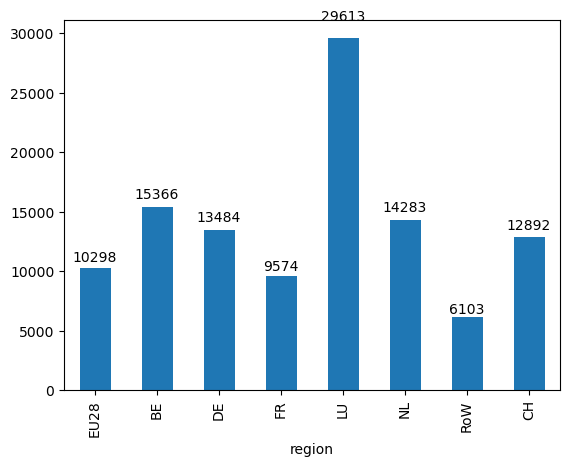

In [17]:
# Comparaison avec les autres régions, per capita
GWP = io_LU.impacts.D_cba_cap.loc[ind]
scale = 1
ax = GWP.plot.bar()
for i,row in enumerate(GWP.items()):
    ax.annotate(f'{row[1]/scale:.0f}',(i,row[1]*1.05), ha='center')

## Part des transactions liée à la demande du Luxembourg

Calculons maintenant les interactions entre pays dues à la demande finale du Luxembourg. La formule pour le calcul qui nous intéresse est $$GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$$

Nous calculerons aussi la "cartographie" de l'ensemble des émissions liées aux échanges mondiaux.
$$GHG_{cons pro}=\widehat{S_{GWP100}}L\widehat{y}$$

### Calcul en partant de la table complète (non-agrégée)
Le protocole ici prend en compte la résolution économique et régionale la plus fine, calcule les émissions liées aux échanges internationaux, et seulement à la fin, les agrège avec la résolution désirée.

In [92]:
GHG_cons_pro_full   = io.L.multiply(io.impacts.S.loc[ind],axis=0).dot(io.Y.groupby('region',axis=1).sum()).groupby('region',axis=0).sum()

F_Y_agg = io.impacts.F_Y.groupby(level='region',axis=1).sum().loc[ind].groupby(reg_agg_dict).sum()

GHG_cons_pro_agg_FD = pd.DataFrame(np.diag(F_Y_agg), index=F_Y_agg.index, columns=F_Y_agg.index)

GHG_cons_pro_agg    = GHG_cons_pro_full.groupby(reg_agg_dict).sum().groupby(reg_agg_dict, axis=1).sum()

In [93]:
io.impacts.F_Y.loc[ind,'LU'].sum()

1177342612.0764

In [116]:
Y_LU = io.Y['LU'].sum(1)

GHG_cons_pro_LU_full   = io.L.multiply(io.impacts.S.loc[ind],axis=0).multiply(Y_LU).groupby('region', axis=1).sum().groupby('region', axis=0).sum()
GHG_cons_pro_LU_agg    = GHG_cons_pro_LU_full.groupby(reg_agg_dict).sum().groupby(reg_agg_dict, axis=1).sum()

GHG_cons_pro_LU_agg_FD = GHG_cons_pro_LU_agg.copy()
GHG_cons_pro_LU_agg_FD.loc[:,:] = 0
GHG_cons_pro_LU_agg_FD.loc['LU','LU'] = io.impacts.F_Y.loc[ind,'LU'].sum()


### Calcul avec la table agrégée
Le protocole ici utilise la table économique agrégée (secteurs et régions), puis seulement ensuite calcule les émissions liées aux échanges internationaux.

In [19]:
Y_LU = io_LU.Y['LU'].sum(1)

In [20]:
GHG_cons_pro_LU = io_LU.L.multiply(io_LU.impacts.S.loc[ind],axis=0).multiply(Y_LU)
GHG_cons_pro = io_LU.L.multiply(io_LU.impacts.S.loc[ind],axis=0).multiply(io_LU.Y.sum(1))

In [60]:
GHG_cons_pro_LU.loc[:,('TOTAL','TOTAL')] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc[('TOTAL','TOTAL'),:] = GHG_cons_pro_LU.sum(0)

GHG_cons_pro.loc[:,('TOTAL','TOTAL')] = GHG_cons_pro.sum(1)
GHG_cons_pro.loc[('TOTAL','TOTAL'),:] = GHG_cons_pro.sum(0)

In [61]:
Y_LU = io_LU.Y.copy()

for r in io_LU.get_regions():
    if r != 'LU':
        Y_LU[r] = 0

In [62]:
x_LU = io_LU.L.dot(io_LU.Y['LU']).sum(axis=1)
x_LU

region  sector                                                                                                                   
EU28    Agriculture, forestry and fishing                                                                                             421.459020
        Mining and quarrying                                                                                                          220.292784
        Manufacturing                                                                                                                6025.857688
        Information and communication                                                                                                 302.837572
        Water supply; sewerage, waste management and remediation activities                                                           214.439500
                                                                                                                                        ...     


In [63]:
Z_LU = io_LU.A.mul(x_LU, axis=1)

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='region-sector', ylabel='region-sector'>

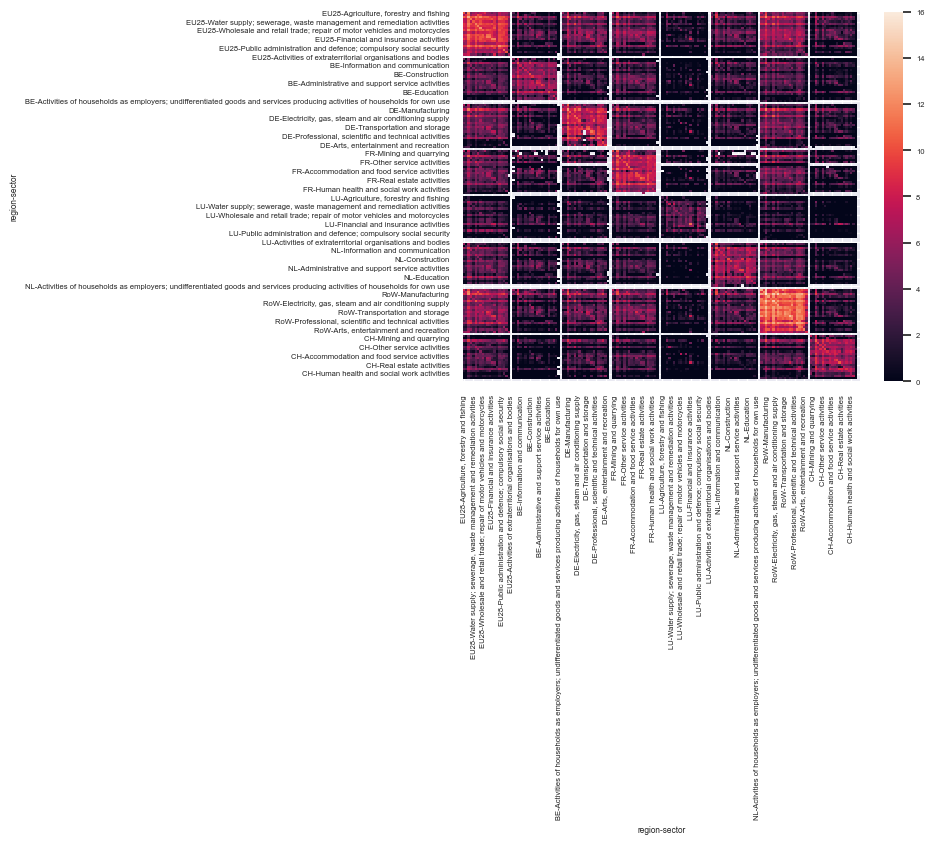

In [64]:
# fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=0.5)
sns.heatmap(np.log(io_LU.Z), vmin=0, vmax=16)

C:\Users\Gibon\.conda\envs\io\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='region-sector', ylabel='region-sector'>

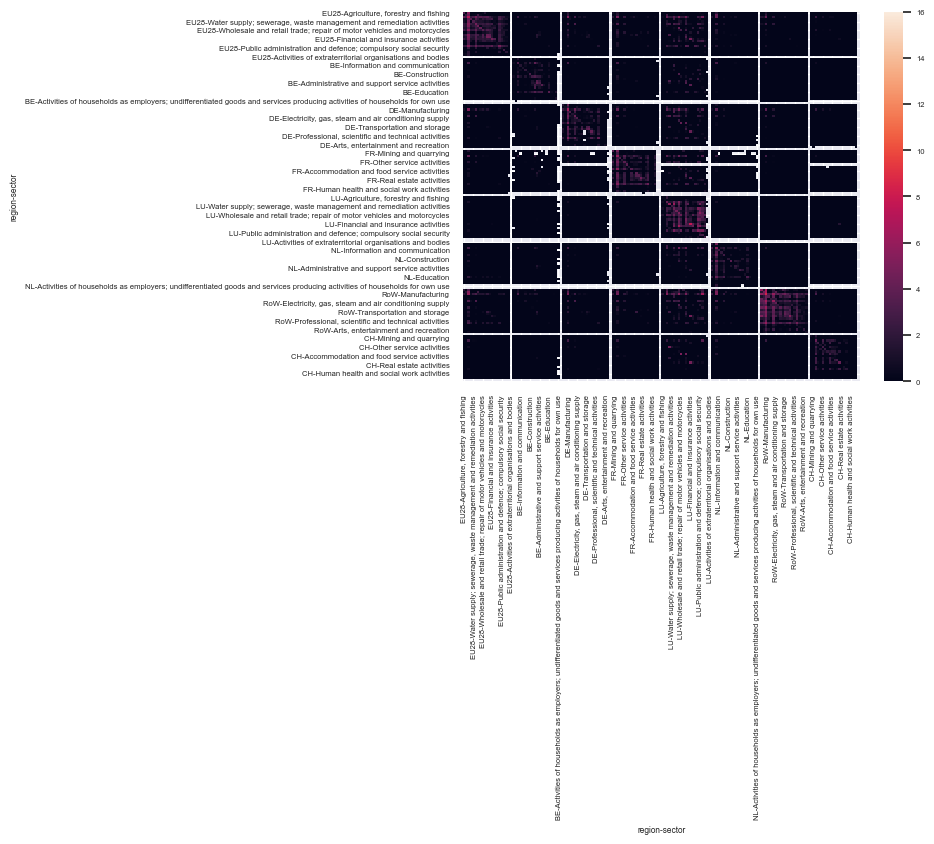

In [65]:
sns.heatmap(np.log(Z_LU), vmin=0, vmax=16)

In [132]:
GHG_cons_pro_FD=pd.DataFrame(np.diag(io_LU.impacts.F_Y.groupby(level='region',axis=1).sum().loc[ind]),
                             index=GHG_cons_pro_LU.index.levels[0][:-1],
                             columns=GHG_cons_pro_LU.columns.levels[0][:-1])

GHG_cons_pro_LU_FD=GHG_cons_pro_FD.copy()
GHG_cons_pro_LU_FD.loc[:,:]=0
GHG_cons_pro_LU_FD.loc['LU','LU']=GHG_cons_pro_FD.loc['LU','LU']

GHG_cons_pro_FD['TOTAL']     = GHG_cons_pro_FD.sum(1)
GHG_cons_pro_FD.loc['TOTAL'] = GHG_cons_pro_FD.sum()

GHG_cons_pro_LU_FD['TOTAL']    = GHG_cons_pro_LU_FD.sum(1)
GHG_cons_pro_LU_FD.loc['TOTAL'] = GHG_cons_pro_LU_FD.sum()

GHG_cons_pro_LU_tot = GHG_cons_pro_LU.groupby(level='region',axis=1).sum().groupby(level='region',axis=0).sum()+GHG_cons_pro_LU_FD
GHG_cons_pro_tot    = GHG_cons_pro.groupby(level='region',axis=1).sum().groupby(level='region',axis=0).sum()+GHG_cons_pro_FD

In [133]:
# GHG_summary = (GHG_cons_pro_agg + GHG_cons_pro_agg_FD)
GHG_summary = GHG_cons_pro_tot.drop('TOTAL').drop('TOTAL', axis=1)

GHG_summary *= 1e-9 # convert to Mt

GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

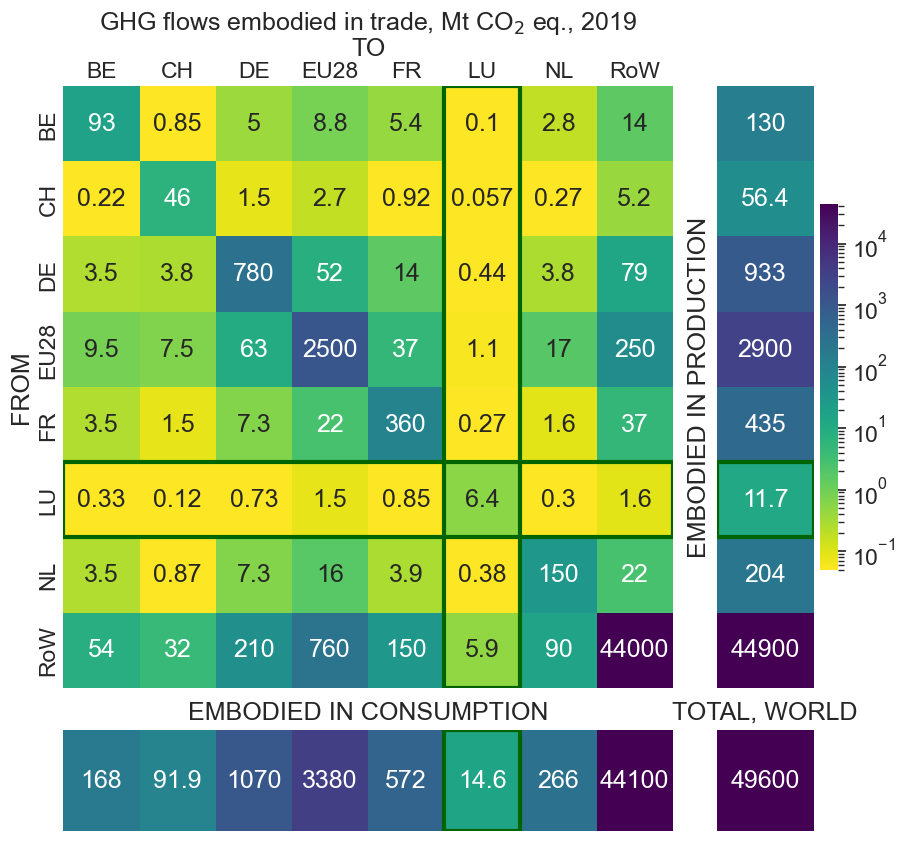

In [134]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=LogNorm(vmin=1, vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2019')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=5
ax[0,0].add_patch(Rectangle((0, hili), 8, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 1, 8, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 1, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

# fig.savefig('GHG_in_trade_{}_FA_wo_LU.svg'.format(year),
#             facecolor='white',
#             edgecolor='none',
#             bbox_inches='tight')

In [122]:
GHG_summary = GHG_cons_pro_LU_agg+GHG_cons_pro_LU_agg_FD

GHG_summary *= 1e-6 # convert to Mt

GWP_all_toplot   = GHG_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GHG_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GHG_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GHG_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

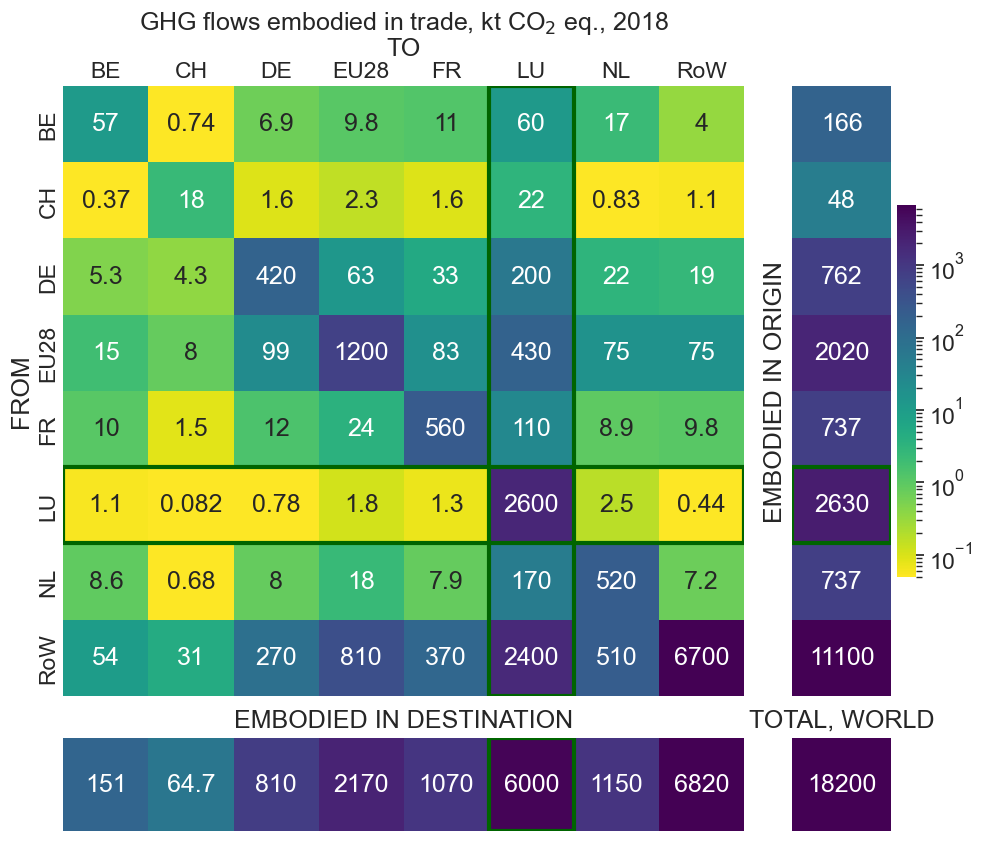

In [126]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(11, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [11, 2],
                                    'height_ratios': [11, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=LogNorm(vmin=1, vmax=GHG_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=LogNorm(vmin=.05, vmax=GHG_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, kt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN ORIGIN')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN DESTINATION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=5
ax[0,0].add_patch(Rectangle((0, hili), 8, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 1, 8, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 1, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 1, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

# fig.savefig('GHG_in_trade_{}_FA_wo_LU.svg'.format(year),
#             facecolor='white',
#             edgecolor='none',
#             bbox_inches='tight')